In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import copy

In [33]:
from PIL import Image

In [2]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D

Using TensorFlow backend.


In [3]:
from keras import backend as K
K.set_image_data_format( 'channels_last' )

In [4]:
def convblock(cdim, nb, bits=3):
    L = []
    
    for k in range(1,bits+1):
        convname = 'conv'+str(nb)+'_'+str(k)
        #L.append( Convolution2D(cdim, 3, 3, border_mode='same', activation='relu', name=convname) ) # Keras 1
        L.append( Convolution2D(cdim, kernel_size=(3, 3), padding='same', activation='relu', name=convname) ) # Keras 2
    
    L.append( MaxPooling2D((2, 2), strides=(2, 2)) )
    
    return L

In [5]:
def vgg_face_blank():
    
    withDO = True 
    
    if True:
        mdl = Sequential()
        
        # First layer is a dummy-permutation = Identity to specify input shape
        mdl.add( Permute((1,2,3), input_shape=(224,224,3)) ) #0 is the sample dim

        for l in convblock(64, 1, bits=2):
            mdl.add(l)

        for l in convblock(128, 2, bits=2):
            mdl.add(l)
        
        for l in convblock(256, 3, bits=3):
            mdl.add(l)
            
        for l in convblock(512, 4, bits=3):
            mdl.add(l)
            
        for l in convblock(512, 5, bits=3):
            mdl.add(l)
        
        
        mdl.add( Convolution2D(4096, kernel_size=(7, 7), activation='relu', name='fc6') ) # Keras 2
        if withDO:
            mdl.add( Dropout(0.5) )
       
        mdl.add( Convolution2D(4096, kernel_size=(1, 1), activation='relu', name='fc7') ) # Keras 2
        if withDO:
            mdl.add( Dropout(0.5) )
      
        mdl.add( Convolution2D(2622, kernel_size=(1, 1), activation='relu', name='fc8') ) # Keras 2
        mdl.add( Flatten() )
        mdl.add( Activation('softmax') )
        
        return mdl
    
    else:
        raise ValueError('not implemented')

In [8]:
facemodel = vgg_face_blank()

In [9]:
facemodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_3 (Permute)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 56, 56, 128)       0         
__________

In [10]:
from scipy.io import loadmat

In [16]:
    data = loadmat('C:\\Users\\Om\\Desktop\\vgg-face.mat', matlab_compatible=False, struct_as_record=False)
    l = data['layers']
    description = data['meta'][0,0].classes[0,0].description

In [17]:
l.shape, description.shape

((1, 37), (2622, 1))

In [18]:
l[0,10][0,0].type[0], l[0,10][0,0].name[0]

('conv', 'conv3_1')

In [20]:
def weight_compare(kmodel):
    kerasnames = [lr.name for lr in kmodel.layers]
    prmt = (0,1,2,3) 

    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        mattype = l[0,i][0,0].type[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print(matname, mattype)
            print(l[0,i][0,0].weights[0,0].transpose(prmt).shape, l[0,i][0,0].weights[0,1].shape)
            print(kmodel.layers[kindex].get_weights()[0].shape, kmodel.layers[kindex].get_weights()[1].shape)
            print('------------------------------------------')
        else:
            print('MISSING : ', matname, mattype)
            print('------------------------------------------')

In [21]:
def copy_mat_to_keras(kmodel):

    kerasnames = [lr.name for lr in kmodel.layers]
    prmt = (0,1,2,3)

    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            
            l_weights = l[0,i][0,0].weights[0,0]
            l_bias = l[0,i][0,0].weights[0,1]
            f_l_weights = l_weights.transpose(prmt)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])

In [23]:
copy_mat_to_keras(facemodel)

In [24]:
featuremodel = Model(inputs=facemodel.layers[0].input, outputs=facemodel.layers[-1].output)

In [34]:
im=Image.open('C:\\Users\\Om\\Desktop\\color_002_test.jpg')
im = im.resize((224,224))

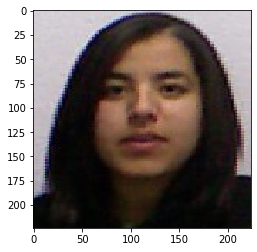

In [35]:
plt.imshow(np.asarray(im))

In [38]:
def pred(kmodel, crpimg, transform=False):
    
    # transform=True seems more robust but I think the RGB channels are not in right order
    
    imarr = np.array(crpimg).astype(np.float32)

    if transform:
        imarr[:,:,0] -= 129.1863
        imarr[:,:,1] -= 104.7624
        imarr[:,:,2] -= 93.5940
        #
        # WARNING : in this script (https://github.com/rcmalli/keras-vggface) colours are switched
        aux = copy.copy(imarr)
        #imarr[:, :, 0] = aux[:, :, 2]
        #imarr[:, :, 2] = aux[:, :, 0]

        #imarr[:,:,0] -= 129.1863
        #imarr[:,:,1] -= 104.7624
        #imarr[:,:,2] -= 93.5940

    #imarr = imarr.transpose((2,0,1)) # INFO : for 'th' setting of 'dim_ordering'
    imarr = np.expand_dims(imarr, axis=0)

    out = kmodel.predict(imarr)

    best_index = np.argmax(out, axis=1)[0]
    best_name = description[best_index,0]
    print(best_index, best_name[0], out[0,best_index], [np.min(out), np.max(out)])

In [39]:
crpim = im 

pred(facemodel, crpim, transform=False)
pred(facemodel, crpim, transform=True)

1917 Olivia_Thirlby 0.47117838 [4.5721941e-07, 0.47117838]
1917 Olivia_Thirlby 0.546615 [3.1088841e-06, 0.546615]


In [37]:
def features(featmodel, crpimg, transform=False):
    
    # transform=True seems more robust but I think the RGB channels are not in right order
    
    imarr = np.array(crpimg).astype(np.float32)

    if transform:
        imarr[:,:,0] -= 129.1863
        imarr[:,:,1] -= 104.7624
        imarr[:,:,2] -= 93.5940        
        aux = copy.copy(imarr)
    imarr = np.expand_dims(imarr, axis=0)

    fvec = featmodel.predict(imarr)[0,:]
    # normalize
    normfvec = math.sqrt(fvec.dot(fvec))
    return fvec/normfvec

In [40]:
f = features(featuremodel, crpim, transform=True)

In [56]:
#print(f)

In [ ]:
#concat features columnwise